In [ ]:
#X est polaire, convertir x en cartesien dans le calcul de y

In [ ]:
#initialisation des variables

#CR en latex, bonus: partie 3.2 et 5
#expliquer le principe du filtre de kalman

import numpy as np

# Paramètres
Te = 1.0  # Période du capteur
T = 100  # Longueur du scénario
sigma_Q = 1  # Écart-type pour Q
sigma_angle = np.pi/180  # Écart-type pour px
sigma_dist = 10  # Écart-type pour py

#de base [sigma_Q, sigma_px, sigma_py] = [1.0, 30.0, 30.0] --> erreur de 7, quasiment pas visible sur la figure
#test1: [sigma_Q, sigma_px, sigma_py] = [10, 300, 300] --> erreur de 89, assez visible sur la figure
#test2: [sigma_Q, sigma_px, sigma_py] = [10, 300, 300] --> erreur de 89, assez visible sur la figure
#verifier que pour une meme trajectoire, lorsque l'on varie le bruit d'observation, lèstimateur est moins bien et vice versa




In [ ]:
#Construction des matrices des matrice

Q = sigma_Q**2 * np.array([
    [Te**3 / 3, Te**2 / 2, 0, 0],
    [Te**2 / 2, Te, 0, 0],
    [0, 0, Te**3 / 3, Te**2 / 2],
    [0, 0, Te**2 / 2, Te]
])

F = np.array([
    [1, Te, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, Te],
    [0, 0, 0, 1]
])

H = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0]
])

R = np.array([
    [sigma_dist**2, 0],
    [0, sigma_angle**2]
])

In [ ]:
# Vecteur d'état initial x_init
r = np.sqrt(3**2 + 16)
teta = np.arctan(-4/3)
x_init = np.array([3, 40, -4, 20]) #polaire

# Vecteur d'état estimé par le filtre de Kalman à l'instant k
x_kalm = x_init

# Initialisation de la matrice de covariance P_kalm comme la matrice identité 4x4
P_kalm = np.eye(4)



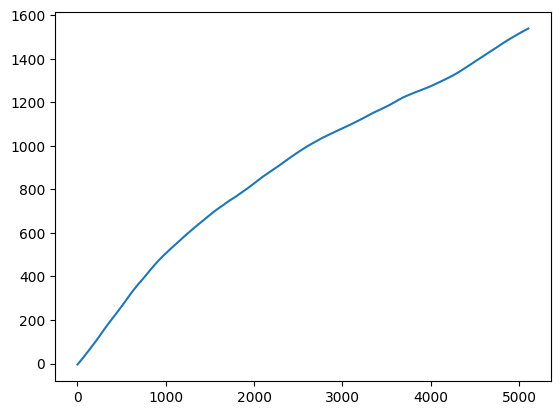

In [ ]:
def creer_trajectoire(F, Q, x_init, T):
  x = np.zeros((4,T))
  #r = np.sqrt(x_init[0]**2, x_init[2]**2)
  #teta = np.arctan(x_init[2]/x_init[0])
  x[:,0] = x_init
  for i in range(1,T):
    U = np.random.multivariate_normal(mean=np.array([0,0,0,0]), cov=Q)
    x[:,i] = np.dot(F,x[:,i-1]) + U
    #x2 = x[0,i]**2 + x[2,i]**2
    #r = np.sqrt(x2)
    #teta = np.arctan(x[2,i]/x[0,i]) #x est composé des cartésiennes
    #x[0,i] = r
    #x[2,i] = teta
  return x

vecteur_x = creer_trajectoire(F, Q, x_init, T)

import matplotlib.pyplot as plt
plt.plot(vecteur_x[0,:], vecteur_x[2,:])



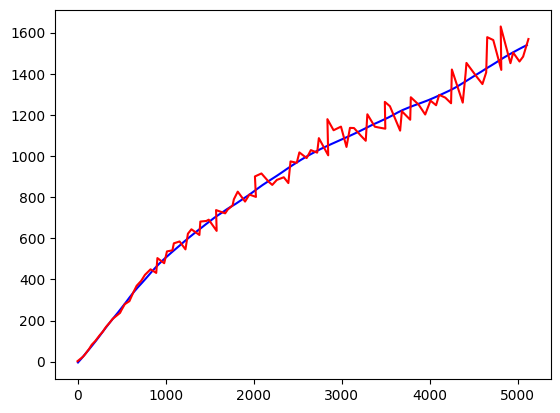

In [ ]:
def creer_observation(H, R, x, T):
  Y = np.zeros((2,T))
  Y[:,0] = np.array([x[0,0], x[2,0]])
  for i in range(1,T):
    x2 = x[0,i]**2 + x[2,i]**2
    r = np.sqrt(x2)
    teta = np.arctan(x[2,i]/x[0,i]) #x est composé des cartésiennes
    V = np.random.multivariate_normal(mean=np.array([0,0]), cov=R)
    Y[:,i] = np.array([r, teta]) + V # la loi devient la loi de V
  return Y

vecteur_y = creer_observation(H, R, vecteur_x, T)

plt.plot(vecteur_x[0,:], vecteur_x[2,:], color = 'blue')
plt.plot(vecteur_y[0,:]*np.cos(vecteur_y[1,:]), vecteur_y[0,:]*np.sin(vecteur_y[1,:]), color = 'red')

In [ ]:
P = np.zeros((T,4,4))
P[1,:,:]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [ ]:
def conv_to_pol(v):
  r = 11

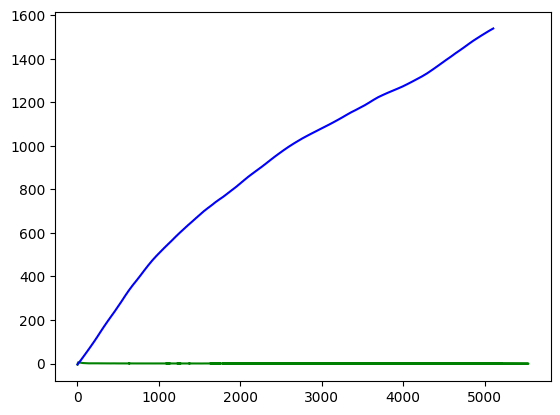

In [ ]:
def filtre_de_kalman_radar(F, Q, R, y_k, x_kalm_prec, P_kalm_prec): #doit etre modifié car on remplace le produit lineaire Hxk par une opération qui n'est plus linéaire en xk
  x = x_kalm_prec
  P = P_kalm_prec
  x_int = np.dot(F,x)
  P_int = Q + np.dot(F,(np.dot(P, F.T)))
  x_int2 = x_int[0]**2 + x_int[2]**2
  x2 = x[0]**2 + x[2]**2
  r = np.sqrt(x2)
  teta = np.arctan(x[2]/x[0])
#il m'aurait fallu h(mt+1/t) et grad_h(mt+1/t) mais grace a la traslation Z je n'ai besoin que de h(mt+1/t)
#h = np.array([r, teta])
  grad_h = np.array([[x_int[0]/r, 0, x_int[2], 0],[-1/x2, 0, x[0]/x2, 0]])
  k = P_int @ grad_h.T @ np.linalg.inv(grad_h @ P_int @ grad_h.T + R)
  x = x_int + np.dot(k, y_k - np.dot(grad_h, x_int))
  P = np.dot(np.eye(4) - np.dot(k,grad_h), P_int)
  return x, P

#P = P_kalm = I4
x_est = np.zeros((4,T))
P = np.zeros((T,4,4))
x_est[:,0] = x_init
P[0,:,:] = P_kalm
for i in range(1,T):
  x_est[:,i] = filtre_de_kalman_radar(F, Q, R, vecteur_y[:,i], vecteur_x[:,i-1], P[i-1,:,:])[0]
  P[i,:,:] = filtre_de_kalman_radar(F, Q, R, vecteur_y[:,i], vecteur_x[:,i-1], P[i-1,:,:])[1]

plt.plot(x_est[0,:], x_est[2,:], color = 'green')
plt.plot(vecteur_x[0,:], vecteur_x[2,:], color = 'blue')
#plt.plot(vecteur_y[0,:], vecteur_y[1,:], color = 'red')

#print(x_est)

In [ ]:
def err_quad_moy(x_reel, x_est):
  n = x_reel.shape[1]
  s = 0
  for i in range(n):
    err_quad = np.dot((x_reel[:,i] - x_est[:,i]).T, x_reel[:,i] - x_est[:,i])
    s += np.sqrt(err_quad)
  return s/n
err_quad_moy(vecteur_x, x_est)


1410.8686338334298

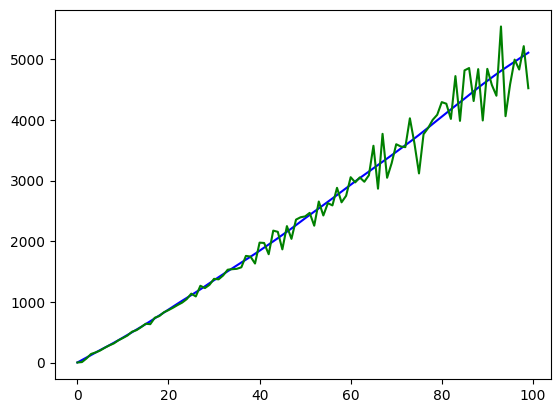

In [ ]:
plt.plot(np.array([i for i in range(T)]), vecteur_x[0,:], color = "blue")
plt.plot(np.array([i for i in range(T)]), x_est[0,:], color = "green")
#plt.plot(np.array([i for i in range(T)]), vecteur_y[0,:], color = 'red')

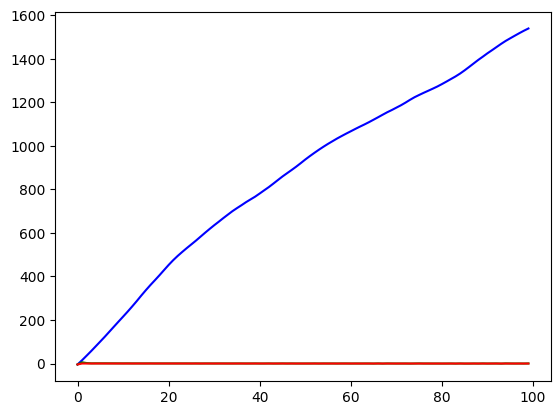

In [ ]:
plt.plot(np.array([i for i in range(T)]), vecteur_x[2,:], color = "blue")
plt.plot(np.array([i for i in range(T)]), x_est[2,:], color = "green")
plt.plot(np.array([i for i in range(T)]), vecteur_y[1,:], color = 'red')

In [ ]:
#variation des bruits de processus σQ, σpx et σpy.


In [ ]:
'''principaux obstacles `a l’utilisation
directe du filtre de Kalman pour la poursuite multi-cibles ?
Ambiguïté de l'association des cibles : Dans une scène vidéo avec plusieurs objets en mouvement, il peut être difficile d'associer correctement les mesures aux cibles correspondantes. Cela peut conduire à des erreurs d'association, ce qui compromet la précision de la poursuite.
Occlusions : Les objets peuvent être partiellement ou complètement occultés par d'autres objets, rendant difficile la mise à jour précise de l'état de la cible. Cela peut entraîner des erreurs dans la prédiction et la correction de la trajectoire.
Modèle de mesure non linéaire : Si le modèle de mesure n'est pas linéaire, cela peut compliquer l'application directe du filtre de Kalman, qui repose sur des équations linéaires. Dans de tels cas, des adaptations comme le filtre de Kalman étendu (EKF) ou le filtre de Kalman unscented (UKF) peuvent être nécessaires.
Gestion des cibles multiples : La gestion simultanée de plusieurs cibles peut augmenter la complexité du suivi, car les interactions entre les différentes cibles doivent être prises en compte.


SyntaxError: ignored

In [ ]:
'''Que faudrait il faire pour pouvoir utiliser simultan´ement plusieurs filtres de Kalman, afin de pister
chaque cible ?
Pour utiliser simultanément plusieurs filtres de Kalman afin de suivre plusieurs cibles, vous pouvez mettre en œuvre une approche de suivi multi-cibles. Voici les étapes générales que vous pourriez suivre :

1. **Détection des cibles :** Utilisez un algorithme de détection pour identifier les objets dans chaque image de la séquence vidéo. Ceci peut être fait en utilisant des techniques de détection d'objets, telles que YOLO (You Only Look Once), SSD (Single Shot Multibox Detector), Faster R-CNN, etc.

2. **Initialisation des filtres de Kalman :** Pour chaque nouvelle cible détectée, initialisez un nouveau filtre de Kalman. L'état initial du filtre serait basé sur la position détectée de la cible et d'autres informations pertinentes.

3. **Prédiction et mise à jour :** Pour chaque image suivante, appliquez la prédiction du mouvement à chaque filtre de Kalman pour estimer la position future de la cible. Ensuite, utilisez les nouvelles mesures provenant de la détection actuelle pour mettre à jour les filtres de Kalman.

4. **Association de cibles :** Après la détection, utilisez une méthode d'association pour attribuer correctement les mesures aux filtres de Kalman correspondants. Cela peut impliquer l'utilisation d'algorithmes d'association de cibles tels que le filtre de Kalman étendu (EKF), le filtre de Kalman unscented (UKF), ou d'autres méthodes de suivi multi-cibles.

5. **Gestion des filtres de Kalman :** Suivez chaque cible avec son propre filtre de Kalman, mettez à jour les filtres en fonction des mesures associées, et gérez la création et la suppression dynamique des filtres de Kalman en fonction de l'apparition ou de la disparition de cibles.

6. **Considération des interactions :** Si les cibles interagissent entre elles, ajustez les modèles de mouvement et les stratégies d'association pour tenir compte de ces interactions.

7. **Optimisation des performances :** Optimisez les performances du système en ajustant les paramètres des filtres de Kalman, en optimisant les seuils de détection, et en explorant d'autres améliorations possibles.

L'utilisation simultanée de plusieurs filtres de Kalman pour le suivi multi-cibles est une tâche complexe, et il existe plusieurs approches et algorithmes spécialisés pour aborder ces défis. L'adaptation de l'approche aux caractéristiques spécifiques de votre application et l'expérimentation avec différentes méthodes peuvent être nécessaires pour obtenir les meilleurs résultats.
